In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.3 MB/s 
     |████████████████████████████████| 186 kB 6.2 MB/s 
     |████████████████████████████████| 1.2 MB 37.2 MB/s 
     |████████████████████████████████| 46 kB 3.5 MB/s 
     |████████████████████████████████| 56 kB 3.0 MB/s 
     |████████████████████████████████| 51 kB 264 kB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *


- Usa redes neuronales "convolucionales" y redes neuronales recurrentes para predecir la columna "Weekly Sales"

- ¿En cuál lograste mejor error?

> Recuerda validar correctamente (es decir, con los últimas fechas).

In [3]:
import seaborn as sns
import pandas as pd
import torch 
import torch.nn as nn
import torch.nn.functional as F
import fastai.tabular.all as ft
from torch.utils.data import Dataset, DataLoader

In [27]:
stores = pd.read_csv('/content/StoresDataSet.csv')
sales = pd.read_csv('/content/SalesDataSet.csv')
features = pd.read_csv('/content/FeaturesDataSet.csv', index_col='Date', parse_dates=True)

In [28]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [29]:
sales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,05/02/2010,24924.50,False
1,1,1,12/02/2010,46039.49,True
2,1,1,19/02/2010,41595.55,False
3,1,1,26/02/2010,19403.54,False
4,1,1,05/03/2010,21827.90,False


Observamos que el formato de Date difiere del formato de los demás datasets, por lo que lo editamos para que corresponda. 

In [30]:
sales['Date'] = pd.to_datetime(sales.Date, errors='coerce')

In [31]:
sales.index = sales.Date

In [32]:
sales = sales[['Store', 'Dept', 'Weekly_Sales', 'IsHoliday']]

In [33]:
sales.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-05-02,1,1,24924.50,False
2010-12-02,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-05-03,1,1,21827.90,False


In [34]:
features.head()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
Date,,,,,,,,,,,
2010-05-02,1,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
2010-12-02,1,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2010-02-19,1,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
2010-02-26,1,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
2010-05-03,1,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


# **Selección y eliminación de atributos**
---

Antes de aplicar CNN y RNN vamos a explorar los datos con los que vamos a trabajar

## **Stores**
---
"Anonymized information about the 45 stores, indicating the type and size of store"

> Contains additional data related to the store, department, and regional activity for the given dates.


In [35]:
stores.head(2)

,Store,Type,Size
0,1,A,151315
1,2,A,202307


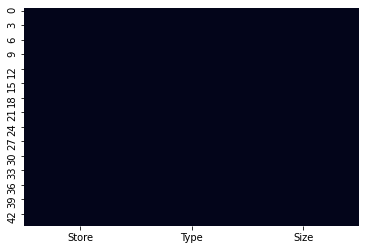

In [36]:
# ESTADO DE LOS DATOS
sns.heatmap(stores.isnull(), cbar=False)

No contiene valores faltantes y la explicación sobre este dataset que ofrece la página de Kaggle de donde fue descargada no es muy amplia. Lo usaremos para combinarlo con uno de los otros datasets

## **Sales**
---
Historical sales data, which covers to 2010-02-05 to 2012-11-01. Within this tab you will find the following fields:

- Store - the store number
- Dept - the department number
- Date - the week
- Weekly_Sales -  sales for the given department in the given store
- IsHoliday - whether the week is a special holiday week

In [37]:
sales.head(2)

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-05-02,1,1,24924.50,False
2010-12-02,1,1,46039.49,True


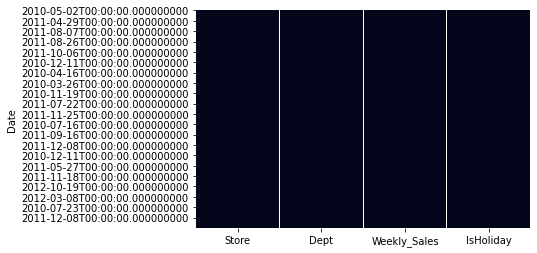

In [38]:
# ESTADO DE LOS DATOS
sns.heatmap(sales.isnull(), cbar=False)

No tenemos valores faltantes, podemos usar sus columnas para combinarlo mediante "Store" con los demás datasets y construir uno a partir de dicha combinación 

In [39]:
sales['Year'] = sales.index.year
sales['Month'] = sales.index.month
sales['Day'] = sales.index.day

In [40]:
sales.head(5)

,Store,Dept,Weekly_Sales,IsHoliday,Year,Month,Day
Date,,,,,,,
2010-05-02,1,1,24924.50,False,2010,5,2
2010-12-02,1,1,46039.49,True,2010,12,2
2010-02-19,1,1,41595.55,False,2010,2,19
2010-02-26,1,1,19403.54,False,2010,2,26
2010-05-03,1,1,21827.90,False,2010,5,3


## **Features**
---
Contains additional data related to the store, department, and regional activity for the given dates.

- Store - the store number
- Date - the week
- Temperature - average temperature in the region
- Fuel_Price - cost of fuel in the region
- MarkDown1-5 - anonymized data related to promotional markdowns. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA
- CPI - the consumer price index
- Unemployment - the unemployment rate
- IsHoliday - whether the week is a special holiday week


In [41]:
features.head(2)

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
Date,,,,,,,,,,,
2010-05-02,1,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
2010-12-02,1,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True


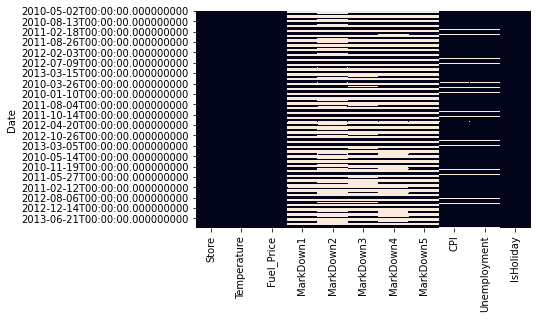

In [42]:
# Estado de los datos
sns.heatmap(features.isnull(), cbar=False)

Dado que los datos relacionados a rebajas **Markdowns**
solo estan disponibles a partir de Nov 2011 y sólo están disponibles para algunas tiendas. Vamos a suprimirlos para esta primer predicción. 

> Tal vez los usemos más adelante únicamente para ver si rellenando con el anterior registro o algo así, nos aportan información y mejoran nuestra predicción. 

In [43]:
features.columns

Index(['Store', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday'],
      dtype='object')

In [44]:
features = features[['Store', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday']]
features.head()

,Store,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday
Date,,,,,,
2010-05-02,1,42.31,2.572,211.096358,8.106,False
2010-12-02,1,38.51,2.548,211.242170,8.106,True
2010-02-19,1,39.93,2.514,211.289143,8.106,False
2010-02-26,1,46.63,2.561,211.319643,8.106,False
2010-05-03,1,46.50,2.625,211.350143,8.106,False


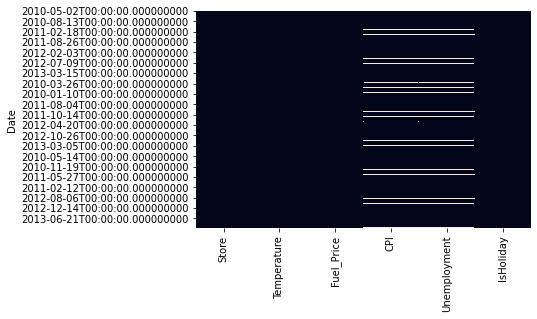

In [45]:
sns.heatmap(features.isnull(), cbar=False)

In [46]:
features['Year'] = features.index.year
features['Month'] = features.index.month
features['Day'] = features.index.day

In [47]:
features.head(3)

,Store,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Year,Month,Day
Date,,,,,,,,,
2010-05-02,1,42.31,2.572,211.096358,8.106,False,2010,5,2
2010-12-02,1,38.51,2.548,211.242170,8.106,True,2010,12,2
2010-02-19,1,39.93,2.514,211.289143,8.106,False,2010,2,19


Unimos los dataframes para generar uno y trabajar con el.

In [48]:
features.columns, len(features)

(Index(['Store', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
        'IsHoliday', 'Year', 'Month', 'Day'],
       dtype='object'), 8190)

In [49]:
len(set(features.Store))

45

In [50]:
sales.columns, len(sales)

(Index(['Store', 'Dept', 'Weekly_Sales', 'IsHoliday', 'Year', 'Month', 'Day'], dtype='object'),
 421570)

In [51]:
sales.Store.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

In [52]:
stores.columns, len(stores)

(Index(['Store', 'Type', 'Size'], dtype='object'), 45)

In [53]:
len(set(stores.Store))

45

Dado que _sales_ únicamente tiene 4 tiendas y es donde se encuentra la columna que vamos a predecir, voy a reducir los otros dos dataframes de tal forma que me quede únicamente con esas cuatro tiendas en todos. Esto para facilitar la unión entre ellos. Ya que he estado batallando bastante con ellos

In [54]:
# TODO: Filtrado a 1,2,3,4 de features
filter_features = features.loc[(features.Store == 1) | (features.Store == 2) | (features.Store == 3) | (features.Store == 4)]

In [55]:
len(set(filter_features.Store)), len(filter_features)

(4, 728)

In [56]:
# TODO: Filtrado a 1,2,3,4 de stores
filter_stores = stores.loc[(stores.Store == 1) | (stores.Store == 2) | (stores.Store == 3) | (stores.Store == 4)]

In [57]:
len(set(filter_stores.Store)), len(filter_stores)

(4, 4)

In [58]:
# TODO: sales
len(set(sales.Store)), len(sales)

(45, 421570)

In [59]:
# para no perder generalidad
filter_sales = sales

Una vez tenemos las cuatro tiendas con registros en cada dataset, vamos a unirlas en un sólo dataset. Recordemos que previamente ya habíamos asignado *Date* como el index, sin embargo, ahora lo cambiamos y asignamos *Store* como el index, esto con la finalidad de facilitar la únión entre los diferentes datasets.

In [60]:
# TODO: cambio de indice en Features
filter_features['Date'] = filter_features.index

SettingWithCopyError: ignored

In [61]:
filter_features.head(1)

,Store,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Year,Month,Day,Date
Date,,,,,,,,,,
2010-05-02,1,42.31,2.572,211.096358,8.106,False,2010,5,2,2010-05-02


Es raro, pero la instrucción anterior a pesar de que marco error si fue ejecutada

In [62]:
#filter_features.index = filter_features["Store"]

In [63]:
filter_features.head(2)

,Store,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Year,Month,Day,Date
Date,,,,,,,,,,
2010-05-02,1,42.31,2.572,211.096358,8.106,False,2010,5,2,2010-05-02
2010-12-02,1,38.51,2.548,211.242170,8.106,True,2010,12,2,2010-12-02


In [64]:
filter_features.columns, len(filter_features)

(Index(['Store', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
        'IsHoliday', 'Year', 'Month', 'Day', 'Date'],
       dtype='object'), 728)

In [65]:
# TODO: Cambio de indice en Sales
filter_sales['Date'] = filter_sales.index
#filter_sales.index = filter_sales.Store

In [66]:
filter_sales.head(2)

,Store,Dept,Weekly_Sales,IsHoliday,Year,Month,Day,Date
Date,,,,,,,,
2010-05-02,1,1,24924.50,False,2010,5,2,2010-05-02
2010-12-02,1,1,46039.49,True,2010,12,2,2010-12-02


In [67]:
filter_sales.columns, len(filter_sales)

(Index(['Store', 'Dept', 'Weekly_Sales', 'IsHoliday', 'Year', 'Month', 'Day',
        'Date'],
       dtype='object'), 421570)

In [68]:
# TODO: Cambio de indice en stores
#filter_stores.index = filter_stores.Store
filter_stores.head(2)

,Store,Type,Size
0,1,A,151315
1,2,A,202307


In [69]:
filter_stores.columns, len(filter_stores)

(Index(['Store', 'Type', 'Size'], dtype='object'), 4)

Una vez hecho el filtro en todos los datasets. Procedemos a unirlos al data set con más registros, de tal forma que se repitan los atributos de los más pequeños en el más grande.

In [70]:
len(filter_sales), len(filter_features), len(filter_stores)

(421570, 728, 4)

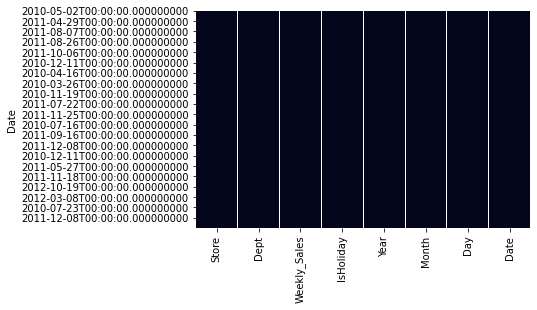

In [71]:
sns.heatmap(filter_sales.isnull(), cbar=False)

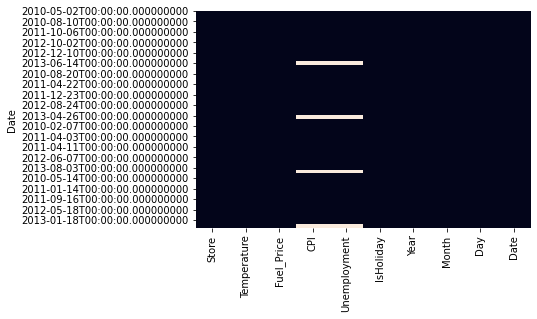

In [72]:
sns.heatmap(filter_features.isnull(), cbar=False)

In [73]:
# TODO: Eliminamos los registros que tienen valores nulos
filter_features = filter_features.dropna()

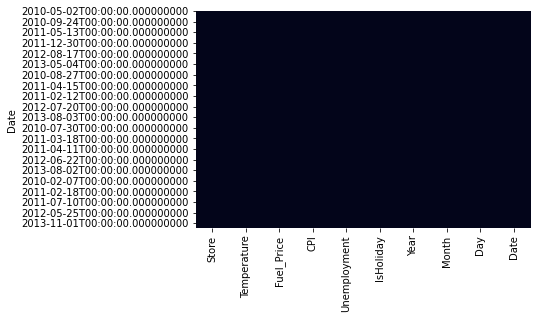

In [74]:
sns.heatmap(filter_features.isnull(), cbar=False)

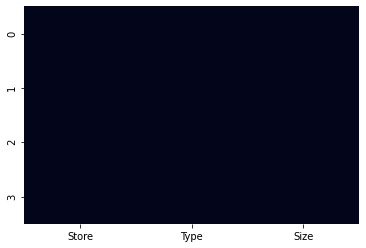

In [75]:
sns.heatmap(filter_stores.isnull(), cbar=False)

In [76]:
len(filter_sales), len(filter_features), len(filter_stores)

(421570, 676, 4)

In [77]:
filter_sales.columns, filter_features.columns, filter_stores.columns

(Index(['Store', 'Dept', 'Weekly_Sales', 'IsHoliday', 'Year', 'Month', 'Day',
        'Date'],
       dtype='object'),
 Index(['Store', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
        'IsHoliday', 'Year', 'Month', 'Day', 'Date'],
       dtype='object'),
 Index(['Store', 'Type', 'Size'], dtype='object'))

In [78]:
# TODO: Unimos los dos primeros dataframes
result_tmp = pd.merge(filter_sales, filter_features, on='Store', how="inner", suffixes=('_sales', '_features'))

In [79]:
len(result_tmp)

6724510

In [80]:
filter_stores.columns, result_tmp.columns

(Index(['Store', 'Type', 'Size'], dtype='object'),
 Index(['Store', 'Dept', 'Weekly_Sales', 'IsHoliday_sales', 'Year_sales',
        'Month_sales', 'Day_sales', 'Date_sales', 'Temperature', 'Fuel_Price',
        'CPI', 'Unemployment', 'IsHoliday_features', 'Year_features',
        'Month_features', 'Day_features', 'Date_features'],
       dtype='object'))

In [81]:
# Ahora le pasamos el tipo de tienda y el tamaño
df = pd.merge(result_tmp, filter_stores, on='Store', suffixes=('_merge_sales_features', '_stores'))

In [82]:
len(df)

6724510

In [83]:
#sns.heatmap(df.isnull(), cbar=False)

In [84]:
df.head()

,Store,Dept,Weekly_Sales,IsHoliday_sales,Year_sales,Month_sales,Day_sales,Date_sales,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday_features,Year_features,Month_features,Day_features,Date_features,Type,Size
0,1,1,24924.5,False,2010,5,2,2010-05-02,42.31,2.572,211.096358,8.106,False,2010,5,2,2010-05-02,A,151315
1,1,1,24924.5,False,2010,5,2,2010-05-02,38.51,2.548,211.242170,8.106,True,2010,12,2,2010-12-02,A,151315
2,1,1,24924.5,False,2010,5,2,2010-05-02,39.93,2.514,211.289143,8.106,False,2010,2,19,2010-02-19,A,151315
3,1,1,24924.5,False,2010,5,2,2010-05-02,46.63,2.561,211.319643,8.106,False,2010,2,26,2010-02-26,A,151315
4,1,1,24924.5,False,2010,5,2,2010-05-02,46.50,2.625,211.350143,8.106,False,2010,5,3,2010-05-03,A,151315


In [85]:
df['Date'] = pd.to_datetime(df['Date_sales'], errors='coerce')
df.index = df['Date']
df.head()

,Store,Dept,Weekly_Sales,IsHoliday_sales,Year_sales,Month_sales,Day_sales,Date_sales,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday_features,Year_features,Month_features,Day_features,Date_features,Type,Size,Date
Date,,,,,,,,,,,,,,,,,,,,
2010-05-02,1,1,24924.5,False,2010,5,2,2010-05-02,42.31,2.572,211.096358,8.106,False,2010,5,2,2010-05-02,A,151315,2010-05-02
2010-05-02,1,1,24924.5,False,2010,5,2,2010-05-02,38.51,2.548,211.242170,8.106,True,2010,12,2,2010-12-02,A,151315,2010-05-02
2010-05-02,1,1,24924.5,False,2010,5,2,2010-05-02,39.93,2.514,211.289143,8.106,False,2010,2,19,2010-02-19,A,151315,2010-05-02
2010-05-02,1,1,24924.5,False,2010,5,2,2010-05-02,46.63,2.561,211.319643,8.106,False,2010,2,26,2010-02-26,A,151315,2010-05-02
2010-05-02,1,1,24924.5,False,2010,5,2,2010-05-02,46.50,2.625,211.350143,8.106,False,2010,5,3,2010-05-03,A,151315,2010-05-02


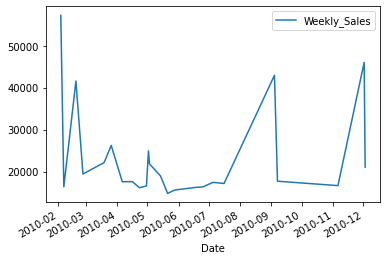

In [86]:
df[['Weekly_Sales']][10:4000].plot()

# Implementación CNN

In [87]:
len(df)

6724510

In [88]:
def error_l1(df, colA, colB): 
  df = df.iloc[-(int(len(df)*0.1)):] # Es lo equivalente a lo que se hizo con daily-min-temperatures.csv
  return np.mean(np.abs(df[colA]-df[colB]))

def error_rmse(df, colA, colB):
  df = df.iloc[-(int(len(df)*0.1)):] 
  return np.sqrt(np.mean(np.square(df[colA]-df[colB])))

In [89]:
df.columns

Index(['Store', 'Dept', 'Weekly_Sales', 'IsHoliday_sales', 'Year_sales',
       'Month_sales', 'Day_sales', 'Date_sales', 'Temperature', 'Fuel_Price',
       'CPI', 'Unemployment', 'IsHoliday_features', 'Year_features',
       'Month_features', 'Day_features', 'Date_features', 'Type', 'Size',
       'Date'],
      dtype='object')

In [90]:
df['ultima_weekly_sales'] = df['Weekly_Sales'].shift(1)
df.head()

,Store,Dept,Weekly_Sales,IsHoliday_sales,Year_sales,Month_sales,Day_sales,Date_sales,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday_features,Year_features,Month_features,Day_features,Date_features,Type,Size,Date,ultima_weekly_sales
Date,,,,,,,,,,,,,,,,,,,,,
2010-05-02,1,1,24924.5,False,2010,5,2,2010-05-02,42.31,2.572,211.096358,8.106,False,2010,5,2,2010-05-02,A,151315,2010-05-02,NaN
2010-05-02,1,1,24924.5,False,2010,5,2,2010-05-02,38.51,2.548,211.242170,8.106,True,2010,12,2,2010-12-02,A,151315,2010-05-02,24924.5
2010-05-02,1,1,24924.5,False,2010,5,2,2010-05-02,39.93,2.514,211.289143,8.106,False,2010,2,19,2010-02-19,A,151315,2010-05-02,24924.5
2010-05-02,1,1,24924.5,False,2010,5,2,2010-05-02,46.63,2.561,211.319643,8.106,False,2010,2,26,2010-02-26,A,151315,2010-05-02,24924.5
2010-05-02,1,1,24924.5,False,2010,5,2,2010-05-02,46.50,2.625,211.350143,8.106,False,2010,5,3,2010-05-03,A,151315,2010-05-02,24924.5


In [91]:
error_rmse(df, 'Weekly_Sales', 'ultima_weekly_sales')
# Tenemos un error bastante grande

948.3297416536519

In [92]:
df.dropna(inplace=True)

In [ ]:
df.columns

Index(['Store', 'Dept', 'Weekly_Sales', 'IsHoliday_sales', 'Year_sales',
       'Month_sales', 'Day_sales', 'Date_sales', 'Temperature', 'Fuel_Price',
       'CPI', 'Unemployment', 'IsHoliday_features', 'Year_features',
       'Month_features', 'Day_features', 'Date_features', 'Type', 'Size',
       'Date', 'ultima_weekly_sales'],
      dtype='object')

In [ ]:
def cargar_datos(df): 
  X = ft.range_of(df)
  valid_cut = len(df) - int(len(df)*0.1)
  # TODO: Por alguna razón, me marcaba error ssi tenia dos campos "iguales" de dataframes diferentes
  # como IsHoliday_sales y IsHoliday_features
  src = ft.TabularPandas(df,
                         cont_names=list(['Store', 'Dept','Temperature', 'Fuel_Price',
       'CPI', 'Unemployment', 'Size', 'ultima_weekly_sales']), # Tomate estas columnas
                         y_names=['Weekly_Sales'], # Para predecir esta
                        splits = (X[:valid_cut], X[valid_cut:])) # primeros para entrerar, últimos para validar
  
  return src.dataloaders(bs=1024)

In [ ]:
dls = cargar_datos(df)

In [ ]:
dls.one_batch()

(tensor([], size=(1024, 0), dtype=torch.int64),
 tensor([[2.0000e+00, 1.3000e+01, 4.5990e+01,  ..., 7.0570e+00, 2.0231e+05, 4.7397e+04],
         [3.0000e+00, 5.4000e+01, 8.1750e+01,  ..., 7.3460e+00, 3.7392e+04, 8.1000e+01],
         [4.0000e+00, 3.3000e+01, 3.5920e+01,  ..., 5.1430e+00, 2.0586e+05, 2.2936e+04],
         ...,
         [2.0000e+00, 4.2000e+01, 8.2640e+01,  ..., 6.5650e+00, 2.0231e+05, 7.7802e+03],
         [1.0000e+00, 9.0000e+00, 5.2920e+01,  ..., 6.5730e+00, 1.5132e+05, 2.1063e+04],
         [4.0000e+00, 2.6000e+01, 7.8110e+01,  ..., 4.3080e+00, 2.0586e+05, 1.7181e+04]]),
 tensor([[47396.9297],
         [   81.0000],
         [22936.4199],
         ...,
         [ 7780.2300],
         [21062.6797],
         [17180.6699]]))

In [ ]:
def rmse_loss(pred, targ): 
  return torch.sqrt(F.mse_loss(pred, targ))

In [ ]:
learn = ft.tabular_learner(dls, layers=[128, 128], metrics=[F.l1_loss, rmse_loss])

SuggestedLRs(valley=0.10000000149011612)

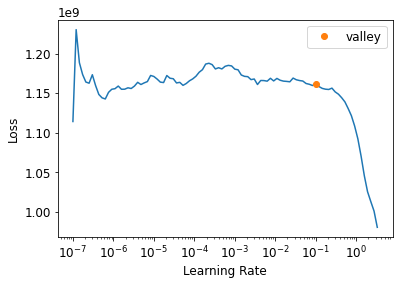

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-1)

epoch,train_loss,valid_loss,l1_loss,rmse_loss,time
0,3125687.000000,1937128.625000,854.076294,1022.612427,02:53
1,3154831.500000,7908289.500000,2433.619629,2506.568848,02:51
2,3718662.250000,2568804.750000,1055.213135,1231.993774,02:36
3,3162434.750000,958083.000000,153.045380,434.693237,02:42
4,2741462.000000,1087581.875000,201.593903,460.271637,02:37


Podemos observar que el train_loss a superado en valor al valid_loss por lo que estamos frente a un overfitting.


Vamos a añadir algunos campos y a volver a entrenar

In [ ]:
import statsmodels as sm
from statsmodels.tsa.filters.hp_filter import hpfilter

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# hpfilter me regresa dos cosas: el trend y el cycle
week_trend, week_cycle = hpfilter(df['Weekly_Sales'], lamb=6.25)

In [ ]:
df['weekly_cycle'] = week_cycle
df['weekly_trend'] = week_trend

In [ ]:
df['EWMA'] = df['Weekly_Sales'].ewm(alpha=0.5).mean()
# alpha debe ser un número entre 0 y 1

In [ ]:
df.columns

Index(['Store', 'Dept', 'Weekly_Sales', 'IsHoliday_sales', 'Year_sales',
       'Month_sales', 'Day_sales', 'Date_sales', 'Temperature', 'Fuel_Price',
       'CPI', 'Unemployment', 'IsHoliday_features', 'Year_features',
       'Month_features', 'Day_features', 'Date_features', 'Type', 'Size',
       'Date', 'ultima_weekly_sales', 'weekly_cycle', 'weekly_trend', 'EWMA'],
      dtype='object')

In [ ]:
def cargar_datos_plus(df): 
  X = ft.range_of(df)
  valid_cut = len(df) - int(len(df)*0.1)
  # TODO: Por alguna razón, me marcaba error ssi tenia dos campos "iguales" de dataframes diferentes
  # como IsHoliday_sales y IsHoliday_features
  src = ft.TabularPandas(df,
                         cont_names=list(['Store', 'Dept','Temperature', 'Fuel_Price',
       'CPI', 'Unemployment', 'Size', 'ultima_weekly_sales', 'ultima_weekly_sales',
        'weekly_cycle', 'weekly_trend', 'EWMA']), # Tomate estas columnas
                         y_names=['Weekly_Sales'], # Para predecir esta
                        splits = (X[:valid_cut], X[valid_cut:])) # primeros para entrerar, últimos para validar
  
  return src.dataloaders(bs=1024)

In [ ]:
dls_plus = cargar_datos_plus(df)

In [ ]:
learn_plus = ft.tabular_learner(dls_plus, layers=[128, 128], metrics=[F.l1_loss, rmse_loss])

SuggestedLRs(valley=0.2089296132326126)

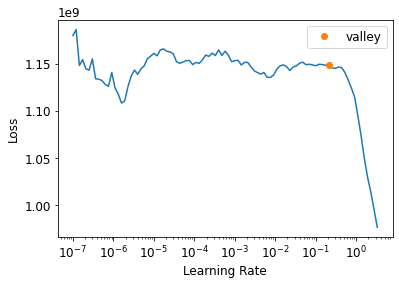

In [ ]:
learn_plus.lr_find()

In [ ]:
learn_plus.fit_one_cycle(5, 1e-1)

epoch,train_loss,valid_loss,l1_loss,rmse_loss,time
0,2722318.250000,4411980.000000,1280.898438,1320.276245,02:40
1,3130500.000000,95742072.000000,8772.512695,8872.188477,02:38
2,2824715.500000,4499293.500000,2058.944824,2070.059326,02:39
3,2260657.750000,5826837.000000,1729.467773,1763.007935,02:46
4,2693506.500000,23254.123047,13.194725,61.268734,02:49


Si bien, podemos observar que nuevamente tenemos un overfitting en nuestro modelo. Observamos que ahora con las nuevas columnas que hemos añadido hemos logrado reducir casi a la mitad el rmse respecto al entrenamiento anterior. 

**NOTA:** He elegido únicamente 5 epocas debido a que google colab es sumamente lenta para entrenar, incluso con la gpu que me proporcionan tarda demasiado. 

# Implementación de RNN

In [ ]:
df.columns

Index(['Store', 'Dept', 'Weekly_Sales', 'IsHoliday_sales', 'Year_sales',
       'Month_sales', 'Day_sales', 'Date_sales', 'Temperature', 'Fuel_Price',
       'CPI', 'Unemployment', 'IsHoliday_features', 'Year_features',
       'Month_features', 'Day_features', 'Date_features', 'Type', 'Size',
       'Date', 'ultima_weekly_sales', 'weekly_cycle', 'weekly_trend', 'EWMA'],
      dtype='object')

In [93]:
T = torch.tensor(df['Weekly_Sales'], dtype=torch.float32)

In [94]:
# para escribir un dataset de pytorch, tenemos que sobreescribir dos cosas
# la longitud (__len__) y otro, el corchete (__getitem__)

class KaggleDataset(Dataset):
  def __init__(self, T, max_window = 60):
    self.T = T # Es el tensor
    self.max_window = max_window # máxima cantidad de temperaturas que va a haber antes de predecir
    # Por cuestiones prácticas le ponemmos 60 (a mayor número, más lenta)

  def __len__(self):
    return len(self.T) # longitud del dataset = longitud del tensor

  def __getitem__(self, i): 
    d = i-self.max_window # toma los primeros registros desde i-max_window
    first = max(0,d)

    # En caso de que eligas el segundo y no haya 60 registros anteriores
    # se concatena un tensor de menos unos para que no haya problemas
    padding = -torch.ones((max(0, -d),))

    # y lo concatemaos al tensor que le vamos a pasar en la dimension 0
    x = torch.cat((padding, self.T[first:i]), dim=0)
    y = self.T[i] # y va a ser el que se trata de predecir

    return x, y

# Modelo

In [95]:
class SimpleRNN(nn.Module):
  def __init__(self, hidden_size, num_layers):
    super().__init__()

    # Modelo recurrente 
    self.rnn = nn.RNN(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

    # predicciones
    self.linear = nn.Linear(hidden_size, 1)

  def forward(self, x): 
    # agregamos una capa de unos, esto ([:, :, None]) es por cuestiones de funcionamiento, entre otras cosas
    y, h_n = self.rnn(x[:, :, None]) # y = la predicción; h_n = la hidden, la última capa escondida

    y = y[:, -1, :] # Cambiamos las dimensiones de y
    return self.linear(y).squeeze()

In [ ]:
model = SimpleRNN(64, 2) # modelo con dos capaz y que hidden_size sea 64

# Manual (con pytorch)

In [97]:
def rmse_error(yp, y):
  w = (yp-y)
  return torch.sqrt((w*w).mean())

In [98]:
train_ds = KaggleDataset(T[:len(df)-5000], max_window=40)
valid_ds = KaggleDataset(T[len(df)-5000:], max_window=40)

In [99]:
train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=256)

In [ ]:
from torch import optim 
from fastprogress.fastprogress import progress_bar

optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 5

In [ ]:
pb = progress_bar(range(epochs))
for epoch in pb: 
  for x, y in train_dl: 
    optimizer.zero_grad()
    yp = model(x)
    loss = F.mse_loss(yp, y)
    loss.backward()
    optimizer.step()
    pb.comment = f'loss: {loss.item():.3f}'

**Ahora debemos validar**

In [ ]:
model.eval() # Ponemos el modelo en modo evaluación 
rmse_total = 0
for x, y in valid_dl:
  yp = model(x)
  rmse_total += rmse_error(yp, y)

In [ ]:
print(f'RMSE: {rmse_total/len(valid_dl)}')

RMSE: 1669.711669921875


# Con Fastai

In [96]:
model = SimpleRNN(64, 2)

In [100]:
dls = ft.DataLoaders.from_dsets(train_ds, valid_ds, bs=256)

In [101]:
learn = ft.Learner(dls, model, opt_func=ft.ranger, loss_func=F.smooth_l1_loss, metrics=[F.l1_loss, rmse_error])

In [ ]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,l1_loss,rmse_error,time
0,21083.365234,646.145142,646.588806,778.999573,48:22
1,20474.480469,479.632050,480.007812,595.423828,44:22
2,20064.146484,401.538055,401.770752,502.380402,42:34


He cortado la ejecución del entrenamiento debido al tiempo que tarda cada epoca. La razón de ello se debe a que quiero seguir avanzando con las tareas restantes. 



# Observaciones
---
Hemos visto que al inicio tuvimos una rmse sumamente grande (1320) y que se ha logrado reducir a uno considerablemente pequeño (61) con el añadimiento de algunas columnas y usando CNN, sin embargo obtuvimos un sobreentrenamiento. 

Haciendo uso de RNN y con las columnas previamente añadidas, así como las dos epocas de entrenamiento que se realizaron observamos que el rmse parece tener una tendencía a la baja sin embargo como podemos observar. Train loss es mayor a valid loss desde un inicio y no parece que eso vaya a cambiar.


Personalmente pienso que el sobreentrenamiento se produce a raíz del preprocesamiento que hice, tengo el presentimiento de que cuando el merge fue empleado no fue de la manera correcta.


Quisiera corregirlo pero no cuenta con una computadora cuyo entrenamiento sea rápido sino al contrario, tendría que esperar un par de horas para ver si las modificaciones que haga surten efecto y ahora mismo no cuento con dicho tiempo ya que hay entregas pendientes tanto en el trabajo como en la Universidad. Lo lamento